In [1]:
from symmer.symplectic import PauliwordOp
from symmer.projection import (
    S3_projection, QubitTapering, CS_VQE_LW, CS_VQE,
    StabilizerIdentification, ObservableBiasing, stabilizer_walk
)
from symmer.symplectic import *
from symmer.utils import exact_gs_energy, gf2_gaus_elim, gf2_basis_for_gf2_rref
from symmer.chem import geometry_from_pubchem, MoleculeBuilder, get_T2_mp2
from matplotlib import pyplot as plt
from functools import reduce
from openfermion import jordan_wigner
from symmer.utils import QubitOperator_to_dict
import json
#import sys
#sys.path.append( '../../../CS-VQE' )
#from utils.cs_vqe_tools_original import *

In [2]:
with open('../data/molecule_data.json', 'r') as jfile:
    molecule_geometries = json.load(jfile)
with open('../data/score_data.json', 'r') as infile:
    scoring_data = json.load(infile)
print(molecule_geometries.keys())

dict_keys(['H2_3-21G_SINGLET', 'H6_STO-3G_SINGLET', 'H2_6-31G_SINGLET', 'H2_6-311G_SINGLET', 'H3+_STO-3G_SINGLET', 'H3+_3-21G_SINGLET', 'HeH+_3-21G_SINGLET', 'HeH+_6-311G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH+_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'CH+_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'B+_STO-3G_SINGLET', 'B_STO-3G_DOUBLET', 'N_STO-3G_QUARTET', 'OH-_STO-3G_SINGLET', 'O_STO-3G_TRIPLET', 'CH2_STO-3G_TRIPLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'C_STO-3G_TRIPLET', 'NH_STO-3G_SINGLET', 'Ne_STO-3G_SINGLET', 'F_STO-3G_DOUBLET', 'Li_STO-3G_DOUBLET', 'BH_STO-3G_SINGLET', 'NeH+_STO-3G_SINGLET', 'NH2-_STO-3G_SINGLET', 'BH3_STO-3G_SINGLET', 'BH2+_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'H4_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'F2_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'CH3NHCH3_STO-3G_SINGLET', 'CH3CH2NH2_STO-3G_SINGLET', 'CH3CH2OH_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3CN_STO-3G_SINGLET', 'CH3CHO_STO-3G_SINGLET', 'CH3CHOHCH3_STO-3

In [3]:
with open('../data/stabilizer_identification_comparision_large.json', 'r') as infile:
    stabilizer_identification_comparision = json.load(infile)

molecules = [speciesname for speciesname in scoring_data if 
             (#scoring_data[speciesname]['n_qubits_post_taper']<=35 and 
              speciesname.find('+')==-1 and
              speciesname.find('-_')==-1 and
              (speciesname.find('O2')==-1 or not speciesname.find('CO2')==-1) and
              speciesname.find('O3')==-1 and
              speciesname.find('SINGLET')!=-1 and
              speciesname not in stabilizer_identification_comparision
             )]
molecules

['F2_STO-3G_SINGLET',
 'N2_STO-3G_SINGLET',
 'CH3CHOHCH3_STO-3G_SINGLET',
 'CH3CHO_STO-3G_SINGLET',
 'CH3CN_STO-3G_SINGLET',
 'CH3CH2OH_STO-3G_SINGLET',
 'CH3CH2NH2_STO-3G_SINGLET',
 'CH3NHCH3_STO-3G_SINGLET',
 'H2O_cc-pVDZ_SINGLET',
 'H2O_6-31g_SINGLET']

In [4]:
def get_score_vs_error(cs_vqe_obj, S, max_sim_q=15):
    stab_score  = cs_vqe_obj.basis_score(S)
    ham_cs = cs_vqe_obj.project_onto_subspace(S, enforce_clique_operator=False)
    n_qubits = ham_cs.n_qubits
    if i<=max_sim_q:
        matrix = ham_cs.to_sparse_matrix
        cs_vqe_energy = exact_gs_energy(matrix)[0]
        #error  = energy-molecule.fci_energy
    else:
        cs_vqe_energy = None
    
    return stab_score, cs_vqe_energy

In [5]:
molecules

['F2_STO-3G_SINGLET',
 'N2_STO-3G_SINGLET',
 'CH3CHOHCH3_STO-3G_SINGLET',
 'CH3CHO_STO-3G_SINGLET',
 'CH3CN_STO-3G_SINGLET',
 'CH3CH2OH_STO-3G_SINGLET',
 'CH3CH2NH2_STO-3G_SINGLET',
 'CH3NHCH3_STO-3G_SINGLET',
 'H2O_cc-pVDZ_SINGLET',
 'H2O_6-31g_SINGLET']

In [6]:
stabilizer_identification_comparision.keys()

dict_keys(['HCN_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'H2O_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET', 'C2H5F_STO-3G_SINGLET', 'C2H6_STO-3G_SINGLET', 'CH3COCH3_STO-3G_SINGLET', 'CH3OCH3_STO-3G_SINGLET', 'CHONH2_STO-3G_SINGLET'])

In [ ]:
for speciesname in molecules:
    print(speciesname)
    # build the molecule
    try:
        mol_data = molecule_geometries[speciesname]
        atoms  = mol_data['atoms']
        coords = mol_data['coords']
        geometry = list(zip(atoms, coords))
        molecule = MoleculeBuilder(geometry=geometry, charge=0, basis='STO-3G', spin=0, run_fci=False, print_info=False)
        
        MP2 = PauliwordOp(
            QubitOperator_to_dict(
                jordan_wigner(
                    get_T2_mp2(
                        molecule.pyscf_obj.pyscf_mp2.t2)
                ), 
                molecule.n_qubits)
        ).sort()

        # taper the Hamiltonian
        taper_hamiltonian = QubitTapering(molecule.H_q)
        hf_array = molecule.H_fermion.hf_comp_basis_state
        taper_hamiltonian.stabilizers.update_sector(hf_array)
        ham_tap = taper_hamiltonian.taper_it(ref_state=hf_array)
        ucc_tap = taper_hamiltonian.taper_it(aux_operator=molecule.T_q, ref_state=hf_array)
        mp2_tap = taper_hamiltonian.taper_it(aux_operator=MP2, ref_state=hf_array)
        hf_tapered = taper_hamiltonian.tapered_ref_state

        # initiate stabilizer identification classes
        Hc_stabilizers = StabilizerIdentification(ham_tap)
        CC_stabilizers = StabilizerIdentification(ucc_tap)
        MP_stabilizers = StabilizerIdentification(mp2_tap)
        #HL_gap = np.where(hf_tapered==0)[0][0]-.5
        #ham_biasing = ObservableBiasing(base_operator=ham_tap, HOMO_LUMO_gap=HL_gap)

        # build CS-VQE model
        cs_vqe = CS_VQE(ham_tap, hf_tapered, basis_weighting_operator=ucc_tap, noncontextual_form='diag')

        data = {'n_sim_qubits':[],
               'stab_score_Hc':[],
               'stab_score_CC':[],
               'stab_score_MP':[],
               'stab_score_HL':[],
               'cs_vqe_nrg_Hc':[],
               'cs_vqe_nrg_CC':[],
               'cs_vqe_nrg_MP':[],
               'cs_vqe_nrg_HL':[]}

        for i in range(1, ham_tap.n_qubits):
            print(i)
            data['n_sim_qubits'].append(i)
            # by Hc
            try:
                S_Hc = Hc_stabilizers.symmetry_basis_by_subspace_dimension(i)
                stab_score_Hc, energy_Hc = get_score_vs_error(cs_vqe, S_Hc)
                data['stab_score_Hc'].append(stab_score_Hc)
                data['cs_vqe_nrg_Hc'].append(energy_Hc)
            except:
                pass
            
            # by CC
            try:
                S_CC = CC_stabilizers.symmetry_basis_by_subspace_dimension(i)
                stab_score_CC, energy_CC = get_score_vs_error(cs_vqe, S_CC)
                data['stab_score_CC'].append(stab_score_CC)
                data['cs_vqe_nrg_CC'].append(energy_CC)
            except:
                pass
            
            # by MP
            try:
                S_MP = MP_stabilizers.symmetry_basis_by_subspace_dimension(i)
                stab_score_MP, energy_MP = get_score_vs_error(cs_vqe, S_MP)
                data['stab_score_MP'].append(stab_score_MP)
                data['cs_vqe_nrg_MP'].append(energy_MP)
            except:
                pass
            # by HOMO-LUMO biasing
            #S_HL = stabilizer_walk(
            #        n_sim_qubits=i, 
            #        biasing_operator=ham_biasing, 
            #        cs_vqe_object=cs_vqe,
            #        #tapering_object=taper_hamiltonian,
            #        #reference_state=hf_array
            #    )
            #stab_score_HL, energy_HL = get_score_vs_error(cs_vqe, S_HL)
            #data['stab_score_HL'].append(stab_score_HL)
            #data['cs_vqe_nrg_HL'].append(energy_HL)

        stabilizer_identification_comparision[speciesname] = {
                'n_qubits_pre_taper': int(molecule.n_qubits),
                'n_qubits_post_taper': int(ham_tap.n_qubits),
                'hf_energy': molecule.hf_energy,
                'mp2_energy': molecule.mp2_energy,
                'ccsd_energy': molecule.ccsd_energy,
                'fci_energy': molecule.fci_energy,
                'noncon_energy': cs_vqe.noncontextual_energy,
                'data':data
            }

        with open('../data/stabilizer_identification_comparision_large.json', 'w') as outfile:
            json.dump(stabilizer_identification_comparision, outfile)
            
    except:
        print('failed')


F2_STO-3G_SINGLET
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
N2_STO-3G_SINGLET
failed
CH3CHOHCH3_STO-3G_SINGLET
1
2
3
4
5
6
7
8
9


In [58]:
#with open('../data/stabilizer_identification_comparision_2.json', 'w') as outfile:
#    json.dump(stabilizer_identification_comparision, outfile)

In [59]:
stabilizer_identification_comparision.keys()

dict_keys(['H2O_STO-3G_SINGLET', 'BeH2_STO-3G_SINGLET', 'Be_STO-3G_SINGLET', 'HF_STO-3G_SINGLET', 'LiH_STO-3G_SINGLET', 'NH3_STO-3G_SINGLET', 'NaCl_STO-3G_SINGLET', 'HCN_STO-3G_SINGLET', 'HCl_STO-3G_SINGLET', 'SiH4_STO-3G_SINGLET', 'H2S_STO-3G_SINGLET', 'CH4_STO-3G_SINGLET', 'HOOH_STO-3G_SINGLET', 'CO2_STO-3G_SINGLET', 'CH3OH_STO-3G_SINGLET'])

In [21]:
def plot_data(data, energy_axis):
    X = np.array(data['data']['n_sim_qubits'])
    Y_Hc = np.array(data['data']['cs_vqe_nrg_Hc'])
    Y_CC = np.array(data['data']['cs_vqe_nrg_CC'])
    Y_MP = np.array(data['data']['cs_vqe_nrg_MP'])
    #Y_HL = np.array(data['data']['cs_vqe_nrg_HL'])
    #Y_legacy = np.array(data['data']['cs_vqe_legacy'])
    Y_score_Hc = np.array(data['data']['stab_score_Hc'])
    Y_score_CC = np.array(data['data']['stab_score_CC'])
    Y_score_MP = np.array(data['data']['stab_score_MP'])
    #Y_score_HL = np.array(data['data']['stab_score_HL'])
    hf_energy = data['hf_energy']
    mp2_energy = data['mp2_energy']
    ccsd_energy = data['ccsd_energy']
    fci_energy = data['fci_energy']
    

    #energy_axis.plot(X, Y_legacy[1:-1]-fci_energy, color='pink', marker='o', label='CS-VQE energy legacy')
    energy_axis.plot(X[:15], Y_Hc[:15]-fci_energy, color='cyan', marker='o', label='CS-VQE energy $H_c$-motivated')
    #energy_axis.plot(X[:15], Y_HL[:15]-fci_energy, color='blue', marker='o', label='CS-VQE energy HOMO-LUMO-bias')
    energy_axis.plot(X[:15], Y_CC[:15]-fci_energy, color='purple', marker='o', label='CS-VQE energy CC-motivated')
    energy_axis.plot(X[:15], Y_MP[:15]-fci_energy, color='pink', marker='o', label='CS-VQE energy MP2-motivated')
    
    if len(Y_Hc)>15:
        energy_axis.vlines(15, 0, 1, color='black')
    energy_axis.hlines(hf_energy-fci_energy, 1, X[-1], ls=':', color='red', label='HF energy')
    energy_axis.hlines(mp2_energy-fci_energy, 1, X[-1], ls=':', color='orange', label='MP2 energy')
    energy_axis.hlines(ccsd_energy-fci_energy, 1, X[-1], ls=':', color='green', label='CCSD energy')
    energy_axis.hlines(0.0016, 1, X[-1], ls=':', color='black', label='Chemical accuracy')
    energy_axis.set_yscale('log')
    energy_axis.set_title(speciesname)
    energy_axis.set_xticks(X)
    
    score_axis = energy_axis.twinx()
    score_axis.plot(X, Y_score_Hc, color='cyan', label='$H_c$-motivated score', marker='.', alpha=0.2, ls='--')
    score_axis.plot(X, Y_score_CC, color='purple', label='CC-motivated score', marker='.', alpha=0.2, ls='--')
    score_axis.plot(X, Y_score_MP, color='pink', label='MP2-motivated score', marker='.', alpha=0.2, ls='--')
    #score_axis.plot(X, Y_score_HL, color='blue', label='HOMO-LUMO-bias score', marker='.', alpha=0.2, ls='--')
    
    #fig.legend(ncol=1, bbox_to_anchor=(1.35,0.5))
    #plt.show()

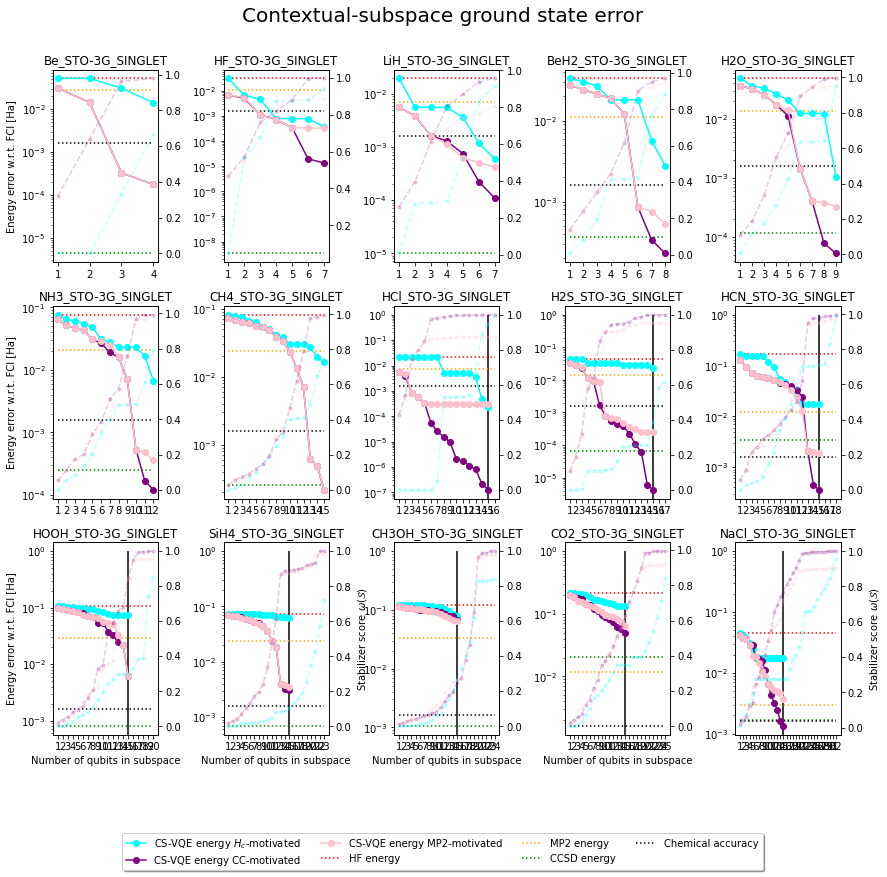

In [22]:
#with open('../data/stabilizer_identification_comparision.json', 'r') as infile:
#    stabilizer_identification_comparision_1 = json.load(infile)
#with open('../data/stabilizer_identification_comparision_2.json', 'r') as infile:
#    stabilizer_identification_comparision = json.load(infile)
#stabilizer_identification_comparision = dict(
#    stabilizer_identification_comparision_1, 
#    **stabilizer_identification_comparision_2)  
    
    
fig,axes = plt.subplots(3,5, figsize=(12,10))#, sharey=True)

sorted_keys = sorted(stabilizer_identification_comparision, 
                     key=lambda x:stabilizer_identification_comparision[x]['n_qubits_post_taper'])

for speciesname, axis in zip(sorted_keys, fig.get_axes()):
    data = stabilizer_identification_comparision[speciesname]
    plot_data(data, axis)
    
fig.tight_layout()

for i in range(4):
    axes[2,i].set_xlabel('Number of qubits in subspace')
for i in range(3):
    axes[i,0].set_ylabel('Energy error w.r.t. FCI [Ha]')

fig.get_axes()[-1].set_ylabel('Stabilizer score $\omega(\mathcal{S})$')
fig.get_axes()[-4].set_ylabel('Stabilizer score $\omega(\mathcal{S})$')

handles, labels = axes[1,1].get_legend_handles_labels()
order = list(range(len(handles)))

fig.suptitle('Contextual-subspace ground state error', size=20, y=1.05)
fig.legend([handles[i] for i in order],
        [labels[i] for i in order],
            loc="lower center",   # Position of legend
            borderaxespad=0.1,    # Small spacing around legend box
            ncol=4,
            bbox_to_anchor=(0.5, -0.15),
            fancybox=True, 
            shadow=True,
            )

plt.show()

In [29]:
chem_acc_scores = []

for speciesname in sorted_keys:
    data = stabilizer_identification_comparision[speciesname]
    fci_energy = data['fci_energy']
    scores = np.array(data['data']['stab_score_CC'])[:15]
    energy = np.array(data['data']['cs_vqe_nrg_CC'])[:15]-fci_energy
    try:
        chem_acc_num_q = np.where(abs(energy)<0.0016)[0][0]
        chem_acc_scores.append(scores[chem_acc_num_q])
    except:
        pass
    
print(chem_acc_scores)
np.mean(chem_acc_scores)

[0.9611676404368508, 0.7590004919191272, 0.8039232033608937, 0.9035024832020045, 0.893375600995969, 0.9666897534064463, 0.9801555495320131, 0.7447295915951525, 0.8986442365109448, 0.9292805715594884, 0.783524780939015]


0.8749085366779913

In [68]:
np.array(stabilizer_identification_comparision['NaCl_STO-3G_SINGLET']['data']['cs_vqe_nrg_CC'])[:15] - stabilizer_identification_comparision['NaCl_STO-3G_SINGLET']['fci_energy']

array([0.04246314214140057, 0.040123278517967265, 0.03759893933579406,
       0.03693943708162806, 0.03165777412618809, 0.023427122864745797,
       0.02237078498808387, 0.020827060830242772, 0.01711082354120208,
       0.01292724820393687, 0.012855067080522531, 0.009844117196280422,
       0.006401540523825133, 0.003032247877399641, 0.0015735743874074615],
      dtype=object)

In [70]:
-614.5689846614488 - stabilizer_identification_comparision['NaCl_STO-3G_SINGLET']['fci_energy']

-3.410605131648481e-13